## Polar Sea Ice Prediction
Code for Ensemble LSTM model

## Initial Setup

In [1]:
import os
import math
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM,TimeDistributed
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from attention import Attention

'wind_10m', 'specific_humidity', 'LW_down', 'SW_down', 'rainfall', 'snowfall', 'sosaline', 'sst', 't2m', 'surface_pressure','sea_ice_extent'

In [2]:
daily_data = np.load('../data/dailyt30_features.npy',allow_pickle=True)
monthly_data = np.load('../data/monthly_features.npy',allow_pickle=True)
daily_target = np.load('../data/dailyt30_target.npy',allow_pickle=True)
monthly_target = np.load('../data/monthly_target.npy',allow_pickle=True)

In [3]:
print(daily_data.shape)
print(monthly_data.shape)
print(monthly_target.shape)

(480, 30, 11)
(480, 1, 11)
(480,)


In [4]:
#Removing data after 2020 for SIO Review Paper submission
# daily_data = daily_data[:-7,:,:]
# monthly_data = monthly_data[:-7,:,:]
# monthly_target = monthly_target[:-7]

# print(daily_data.shape)
# print(monthly_data.shape)
# print(monthly_target.shape)

In [5]:
#Concatenate datasets
data = np.concatenate((daily_data, monthly_data), axis=1)

print(data.shape)

(480, 31, 11)


In [6]:
#Adding a lag to monthly targets
lag = 1
data = data[:-lag,:,:]
monthly_target = monthly_target[lag:]

print(data.shape)
print(monthly_target.shape)

(479, 31, 11)
(479,)


## Train Validation Features Split

In [7]:
# Sequential split train:val data in 80:20 sequentially 

LEN_DATA = len(data) #total number of pixels

# NUM_TRAIN = LEN_DATA - (24+6) #reserve last 30 months for testing 
# NUM_TRAIN = LEN_DATA - (12*20) #reserve last 20 years for testing 
test_years = 7
NUM_TRAIN = LEN_DATA - (12*test_years) #reserve last 20 years for testing 
NUM_VALID = LEN_DATA - NUM_TRAIN

print(f'{LEN_DATA=}', f'i.e. {LEN_DATA / 12:.1f} years')
print(f'{NUM_TRAIN=}', f'i.e. {NUM_TRAIN / 12:.1f} years')
print(f'{NUM_VALID=}', f'i.e. {NUM_VALID / 12:.1f} years')

x_train = data[:NUM_TRAIN]
x_valid = data[NUM_TRAIN:]

#split features and labels
y_train=monthly_target[:NUM_TRAIN] #target is last column i-e sea-ice
y_valid=monthly_target[NUM_TRAIN:] #target is last column i-e sea-ice

LEN_DATA=479 i.e. 39.9 years
NUM_TRAIN=395 i.e. 32.9 years
NUM_VALID=84 i.e. 7.0 years


In [8]:
print(f'{x_train.shape=}')
print(f'{y_train.shape=}')
print(f'{x_valid.shape=}')
print(f'{y_valid.shape=}')

x_train.shape=(395, 31, 11)
y_train.shape=(395,)
x_valid.shape=(84, 31, 11)
y_valid.shape=(84,)


## Normalization


In [9]:
# normalize the features
scaler_f = StandardScaler()
x_train = scaler_f.fit_transform(x_train.reshape(-1,x_train.shape[2])) #reshaping to 2d for standard scaling
x_valid = scaler_f.transform(x_valid.reshape(-1,x_valid.shape[2])) #reshaping to 2d for standard scaling

scaler_l = StandardScaler()
y_train = scaler_l.fit_transform(y_train.reshape(-1,1)) #reshaping to 2d for standard scaling
y_valid = scaler_l.transform(y_valid.reshape(-1,1)) #reshaping to 2d for standard scaling

In [10]:
#All data will be in 2D after Standard Scaling
print(f'{x_train.shape=}')
print(f'{y_train.shape=}')
print(f'{x_valid.shape=}')
print(f'{y_valid.shape=}')

x_train.shape=(12245, 11)
y_train.shape=(395, 1)
x_valid.shape=(2604, 11)
y_valid.shape=(84, 1)


In [11]:
# convert an array of values into a dataset matrix
def reshape_features(dataset, timesteps=1):
    X = dataset.reshape((int(dataset.shape[0]/timesteps)), timesteps, dataset.shape[1])
    print(f'Converted from shape {dataset.shape} to shape {X.shape}')
    return X

In [12]:
#Reshaping data to 3D for modeling
timesteps = 31
x_train = reshape_features(x_train, timesteps) # reshaping to 3d for model
x_valid = reshape_features(x_valid, timesteps) # reshaping to 3d for model

Converted from shape (12245, 11) to shape (395, 31, 11)
Converted from shape (2604, 11) to shape (84, 31, 11)


In [13]:
print(f'{x_train.shape=}')
print(f'{y_train.shape=}')
print(f'{x_valid.shape=}')
print(f'{y_valid.shape=}')

x_train.shape=(395, 31, 11)
y_train.shape=(395, 1)
x_valid.shape=(84, 31, 11)
y_valid.shape=(84, 1)


## LSTM Network

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import concatenate, Permute, Reshape
from tensorflow.keras.layers import Dense, Lambda, Dot, Activation, Concatenate, Flatten
from tensorflow.keras.layers import Layer

In [15]:
# Customized implementation of Attention layer to accomodate multiple calls to attention
# Note that this appears to be the same as the implementation in the 'attention' package. Not clear why this exists.
class CustomAttention(Layer):

    def __init__(self, units=128, **kwargs):
        self.units = units
        super().__init__(**kwargs)

    def __call__(self, inputs):
        """
        Many-to-one attention mechanism for Keras.
        @param inputs: 3D tensor with shape (batch_size, time_steps, input_dim).
        @return: 2D tensor with shape (batch_size, 128)
        @author: felixhao28, philipperemy.
        """
        hidden_states = inputs
        hidden_size = int(hidden_states.shape[2])
        # Inside dense layer
        #              hidden_states            dot               W            =>           score_first_part
        # (batch_size, time_steps, hidden_size) dot (hidden_size, hidden_size) => (batch_size, time_steps, hidden_size)
        # W is the trainable weight matrix of attention Luong's multiplicative style score
        score_first_part = Dense(hidden_size, use_bias=False)(hidden_states)
        #            score_first_part           dot        last_hidden_state     => attention_weights
        # (batch_size, time_steps, hidden_size) dot   (batch_size, hidden_size)  => (batch_size, time_steps)
        h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,))(hidden_states)
        score = Dot(axes=[1, 2])([h_t, score_first_part])
        attention_weights = Activation('softmax')(score)
        # (batch_size, time_steps, hidden_size) dot (batch_size, time_steps) => (batch_size, hidden_size)
        context_vector = Dot(axes=[1, 1])([hidden_states, attention_weights])
        pre_activation = Concatenate()([context_vector, h_t])
        attention_vector = Dense(self.units, use_bias=False, activation='tanh')(pre_activation)
        return attention_vector

    def get_config(self):
        return {'units': self.units}

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [16]:
model1_input= Input(shape=(30,11)) #replace (30,10) with (30,11) for 11 features 
model2_input= Input(shape=(1,11)) #replace (1,10) with (1,11) for 11 features

model1 = Permute((2,1), input_shape=(30,11))(model1_input)
model1 = LSTM(64, return_sequences=True)(model1)
model1 = Dropout(0.2)(model1)
model1 = LSTM(32, return_sequences=True)(model1)
model1 = CustomAttention()(model1)
model1 = Dense(1)(model1)

model2 = Permute((2,1), input_shape=(1,11))(model2_input)
model2 = LSTM(64, return_sequences=True)(model2)
model2 = Dropout(0.2)(model2)
model2 = LSTM(32, return_sequences=True)(model2)
model2 = Attention()(model2)
model2 = Dense(1)(model2)

ensemble = concatenate([model1, model2])
merged_model = Dense(1)(ensemble)
model = Model(inputs=[model1_input,model2_input], outputs=merged_model, name='EALSTM')
model.summary()

Model: "EALSTM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 11)]     0           []                               
                                                                                                  
 permute (Permute)              (None, 11, 30)       0           ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 11, 64)       24320       ['permute[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 11, 64)       0           ['lstm[0][0]']                   
                                                                                             

## Compiling the Network and Fitting Model

In [17]:
#Compiling the network
model.compile(loss='mean_squared_error', optimizer='adam')
checkpoint_path='./testmodel.h5'
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=60, mode='min', min_delta=0.001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

In [18]:
history=model.fit(
    [x_train[:,:30,:],x_train[:,30:31,:]],
    y_train,
    epochs=500,
    batch_size=64,
    verbose=0,
    validation_split=0.3,
    shuffle=True,
    callbacks=keras_callbacks)

2022-02-20 18:42:09.073347: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-20 18:42:10.714958: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-02-20 18:42:10.715031: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM N

## Plotting

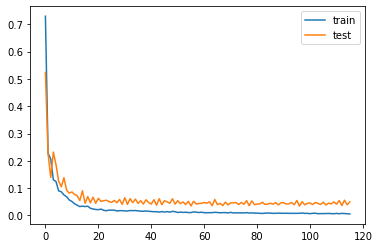

In [19]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Model Predictions

In [20]:
trainPred = model.predict([x_train[:,:30,:],x_train[:,30:31,:]])
testPred = model.predict([x_valid[:,:30,:],x_valid[:,30:31,:]])
print(testPred.shape)
print(trainPred.shape)

(84, 1)
(395, 1)


2022-02-20 18:42:17.982457: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-02-20 18:42:17.982497: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memo

In [21]:
#Reverting data back to 2D from 3D
x_train_t = x_train.reshape(-1, x_train.shape[2])
x_valid_t = x_valid.reshape(-1, x_valid.shape[2])

print(x_train_t.shape)
print(trainPred.shape)
print(x_valid_t.shape)
print(testPred.shape)

(12245, 11)
(395, 1)
(2604, 11)
(84, 1)


In [22]:
# invert scaling for forecasted values 

inv_testPred = scaler_l.inverse_transform(testPred)
print(inv_testPred[:3])

# invert scaling for actual values

inv_y_valid = scaler_l.inverse_transform(y_valid)
print(inv_y_valid[:3])


[[14246371.]
 [14970125.]
 [14858170.]]
[[13860823.]
 [14697697.]
 [15313867.]]


In [23]:
# calculate RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(inv_y_valid, inv_testPred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 854437.009


In [24]:
# calculate Normalized RMSE
y_max = y_valid.max()
y_min = y_valid.min()
nrmse = rmse /(inv_y_valid.mean()) 
print('Test NRMSE:', nrmse)

Test NRMSE: 0.07934580921252872


In [25]:
# calculate R-square
from sklearn.metrics import r2_score
from math import sqrt

r_sq = r2_score(inv_y_valid, inv_testPred)
print('Test R_Square: %.3f' % r_sq)

Test R_Square: 0.936


<BarContainer object of 84 artists>

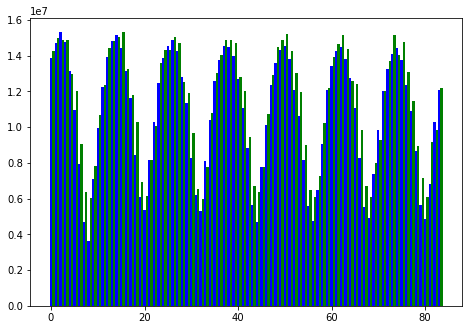

In [26]:
#1 year's plot
import numpy as np
import matplotlib.pyplot as plt
X = np.arange(len(testPred))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, inv_y_valid.flatten(), color = 'b', width = 0.5)
ax.bar(X + 0.5, inv_testPred.flatten(), color = 'g', width = 0.5)

In [27]:
len(inv_testPred)

84

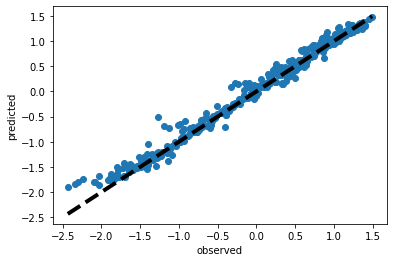

In [28]:
fig, ax = plt.subplots()
ax.scatter(y_train,trainPred)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('observed')
ax.set_ylabel('predicted')
plt.show()

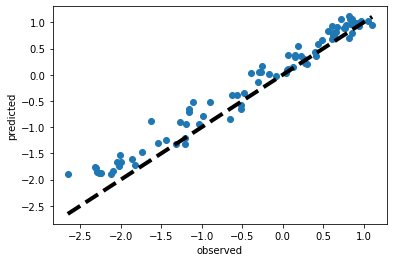

In [29]:
fig, ax = plt.subplots()
ax.scatter(y_valid,testPred) #[:,:,6]
ax.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=4)
ax.set_xlabel('observed')
ax.set_ylabel('predicted')
#plt.savefig('test_prediction.png',bbox_inches='tight',dpi=1200)
plt.show()

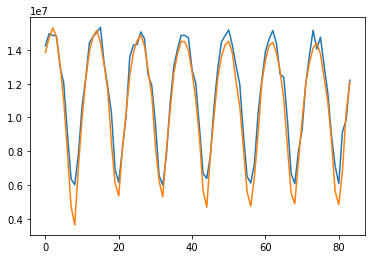

In [30]:
from matplotlib import pyplot

pyplot.plot(inv_testPred, label='predictions')
pyplot.plot(inv_y_valid, label='observation')
pyplot.show()